<a href="https://colab.research.google.com/github/leilaabdel/mammogram-compression-representation/blob/master/notebooks/autoencoder_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Data

In [ ]:
!nvidia-smi

Fri Nov 27 19:50:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import the necessary packages
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

In [ ]:
ROOT = '/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT'
DATA_ROOT = '/content/drive/MyDrive/Machine-Learning-Projects/ddsm-updated'
VIEW = "MLO"
ABNORMALITY = "mass"
HDF5_PATH = f"{DATA_ROOT}/HDF5_datasets/ddsm-{ABNORMALITY}-preprocessed-{VIEW}.h5"


In [ ]:
f = h5py.File(HDF5_PATH, 'r')
f.keys()

<KeysViewHDF5 ['train-breast_density', 'train-mass_margins', 'train-mass_shape', 'train-pathology', 'train-raw-imgs', 'train-roi', 'train-roi_mask', 'train-side']>

In [ ]:
x_train = f['train-raw-imgs']
x_train.shape

(637, 1024, 1024)

# Set Checkpoint Path

In [ ]:
checkpoint_file = "weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
CHECKPOINT_PATH = f"{ROOT}/AE-models/BEST-AE-{checkpoint_file}"
os.makedirs(f"{ROOT}/AE-minimize-reconstruction/" , exist_ok=True)

# Visulize Some Samples

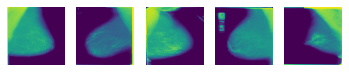

In [ ]:
NUM_TO_VISUALIZE = 5
random_indices = np.random.randint(0 , len(x_train) , size=NUM_TO_VISUALIZE)
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  plt.imshow(x_train[random_indices[i]])



# Convolutional Autoencoder (Regular)

In [ ]:

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")
  



  	# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
   

   		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [ ]:
# construct our dataset
x_train = f['train-raw-imgs']
y_train = f['train-pathology']
y_train = np.asarray(y_train)
x_train = np.expand_dims(x_train , 3)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
y_train

array([2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0,
       0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0,
       0, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1,
       2, 0, 2, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 1, 0, 2, 0, 2, 0, 0,
       2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2,
       2, 0, 1, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 2, 0,
       2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0,
       2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0,
       2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 0, 2,

In [ ]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")

# initialize the number of epochs to train for and batch size
EPOCHS = 1000
BS = 10

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

(encoder, decoder, autoencoder) = ConvAutoencoder.build(x_train.shape[1], x_train.shape[2], x_train.shape[3])
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
autoencoder.evaluate(x_test , x_test , batch_size=16)
autoencoder.load_weights('/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT/AE-minimize-reconstruction/AE-MODEL_1000_EPOCHS.h5')

[INFO] building autoencoder...
8/8 [==============================] - 2s 277ms/step - loss: 0.1452


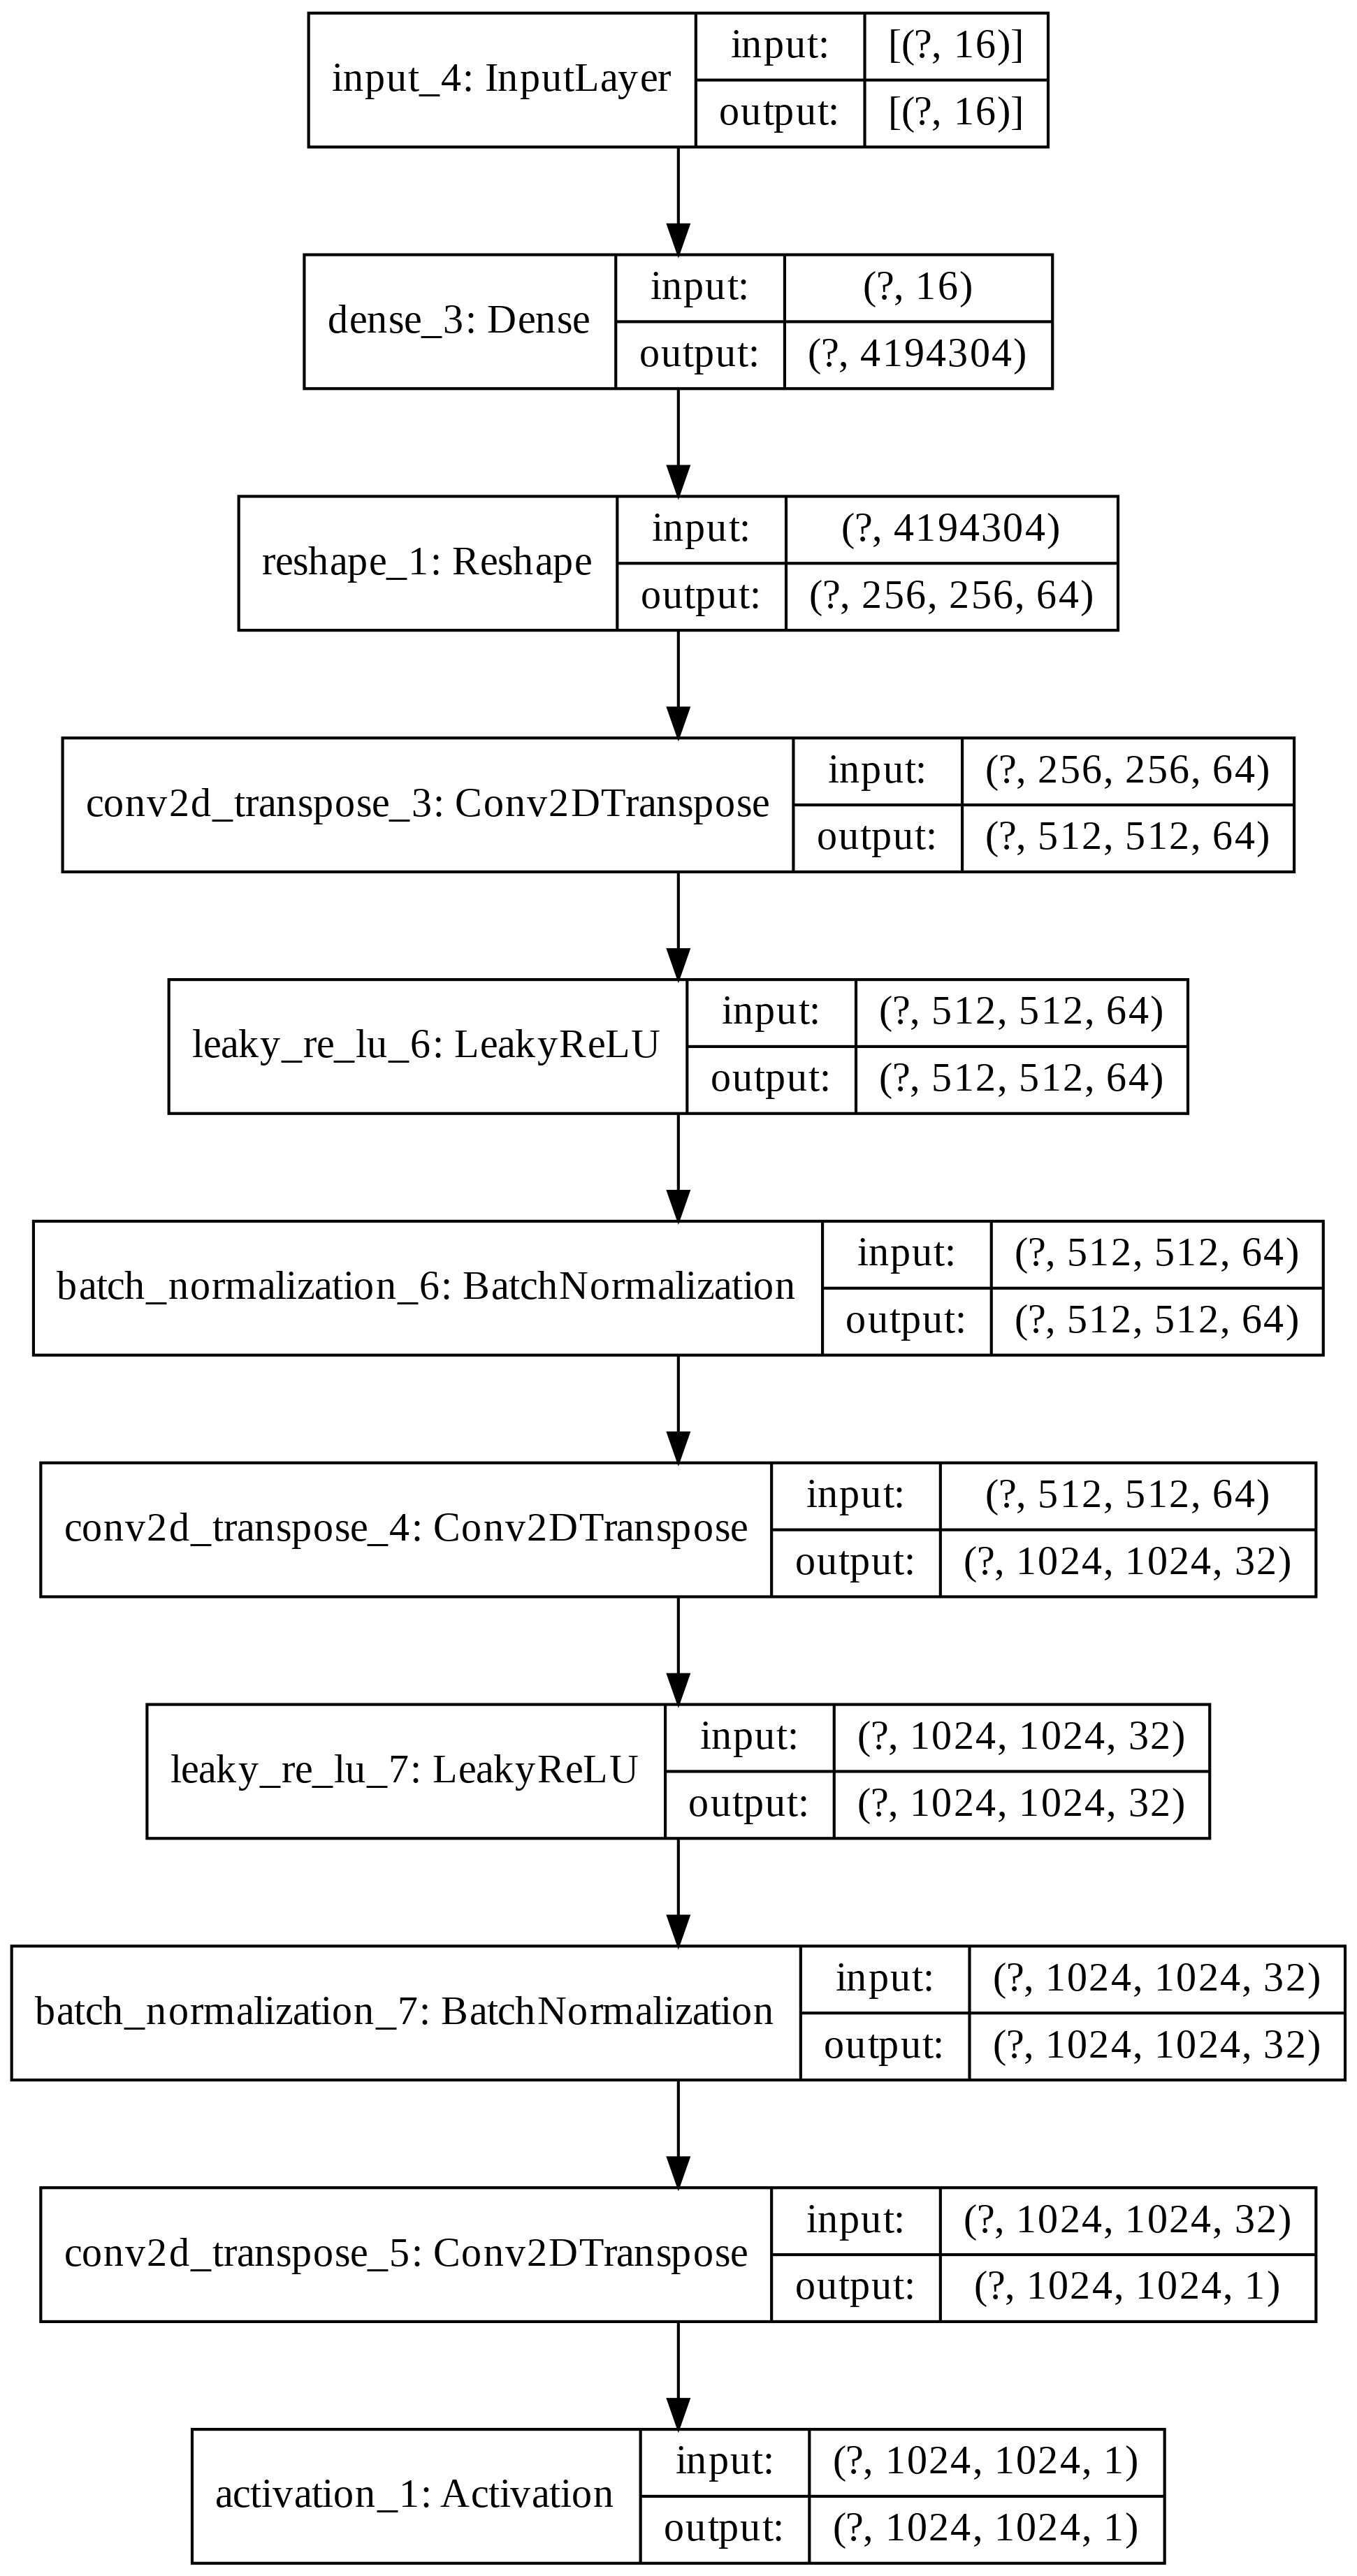

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(decoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=300)

In [ ]:
# # train the convolutional autoencoder
# H = autoencoder.fit(
# 	x_train, x_train,
# 	validation_data=(x_test, x_test),
# 	epochs= EPOCHS,
# 	batch_size=BS , callbacks=[model_checkpoint_callback])

Epoch 1/1000
51/51 [==============================] - 17s 339ms/step - loss: 0.0746 - val_loss: 0.0685
Epoch 2/1000
51/51 [==============================] - 14s 284ms/step - loss: 0.0311 - val_loss: 0.0795
Epoch 3/1000
51/51 [==============================] - 15s 284ms/step - loss: 0.0228 - val_loss: 0.0860
Epoch 4/1000
51/51 [==============================] - 14s 284ms/step - loss: 0.0187 - val_loss: 0.0893
Epoch 5/1000
51/51 [==============================] - 14s 284ms/step - loss: 0.0167 - val_loss: 0.0702
Epoch 6/1000
51/51 [==============================] - 14s 283ms/step - loss: 0.0151 - val_loss: 0.0621
Epoch 7/1000
51/51 [==============================] - 14s 284ms/step - loss: 0.0144 - val_loss: 0.0455
Epoch 8/1000
51/51 [==============================] - 14s 284ms/step - loss: 0.0145 - val_loss: 0.0270
Epoch 9/1000
51/51 [==============================] - 14s 284ms/step - loss: 0.0136 - val_loss: 0.0185
Epoch 10/1000
51/51 [==============================] - 14s 283ms/step - l

# Plot Results

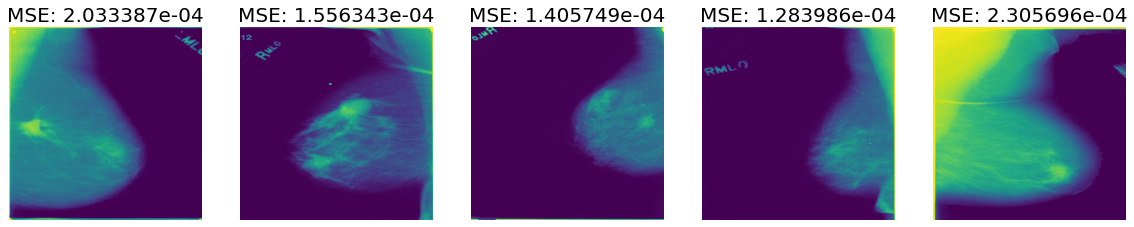

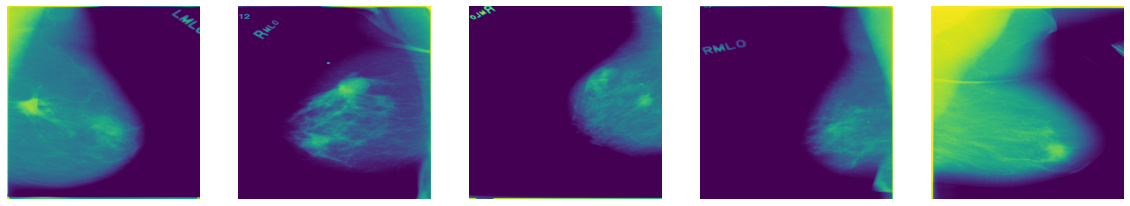

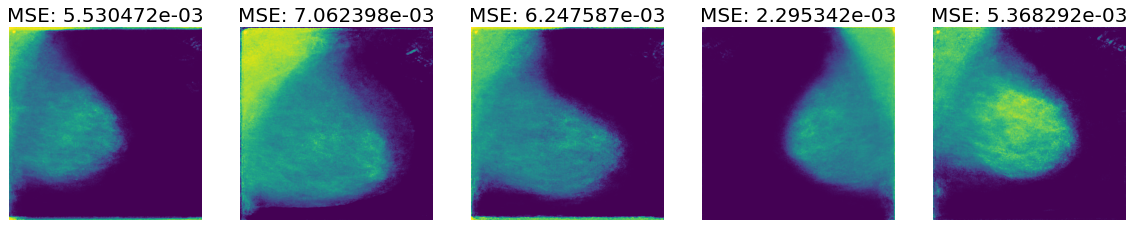

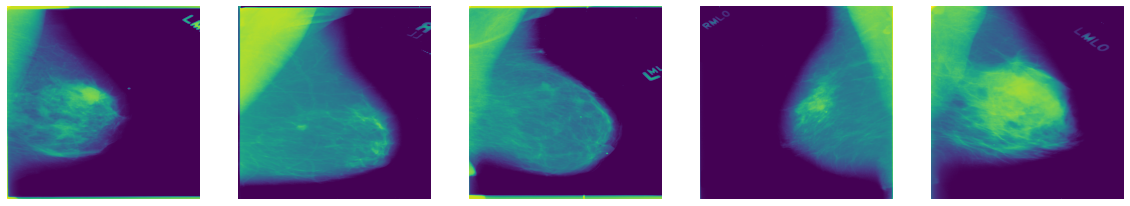

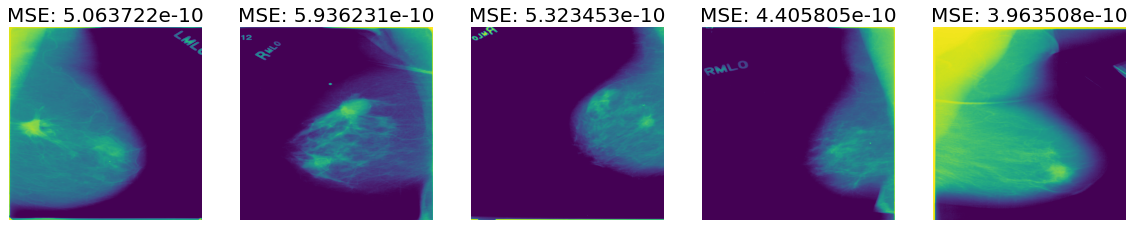

In [ ]:
from sklearn.metrics import mean_squared_error
import sys
import cv2
z_sample_train = encoder.predict(x_train, batch_size=16)
x_decoded_train = decoder.predict(z_sample_train , batch_size=16)

z_sample_test = encoder.predict(x_test, batch_size=16)
x_decoded_test = decoder.predict(z_sample_test , batch_size=16)

plt.figure(figsize=(20,10))
NUM_TO_VISUALIZE = 5
random_indices = np.arange(0 , 5) #np.random.randint(0 , len(x_train) , size=NUM_TO_VISUALIZE)

for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  num = "{:e}".format(mean_squared_error(np.squeeze(x_train[random_indices[i]]) , np.squeeze(x_decoded_train[random_indices[i]])))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.imshow(np.squeeze(x_decoded_train[random_indices[i]]))


plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  plt.imshow(np.squeeze(x_train[random_indices[i]]))

plt.figure(figsize=(20,10))
random_indices = np.arange(0 , 5) #np.random.randint(0 , len(x_test) , size=NUM_TO_VISUALIZE)
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  num = "{:e}".format(mean_squared_error(np.squeeze(x_test[random_indices[i]]) , np.squeeze(x_decoded_test[random_indices[i]])))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.imshow(np.squeeze(x_decoded_test[random_indices[i]]))


plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
  plt.axis('off')
  plt.imshow(np.squeeze(x_test[random_indices[i]]))

plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 85]
  result, encimg = cv2.imencode('.jpg', x_train[i] * 255., encode_param)
  decimg = cv2.imdecode(encimg, 0)
  plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
  num = "{:e}".format((mean_squared_error(np.squeeze(x_train[random_indices[i]]) , decimg / 255.) /  sys.getsizeof(encimg)))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.axis('off')
  plt.imshow(np.squeeze(x_train[i]))


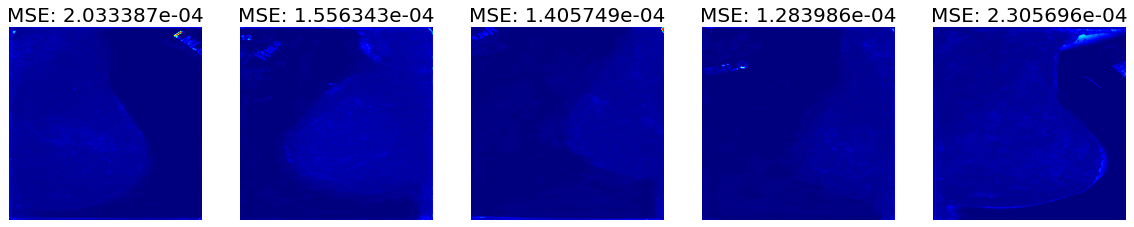

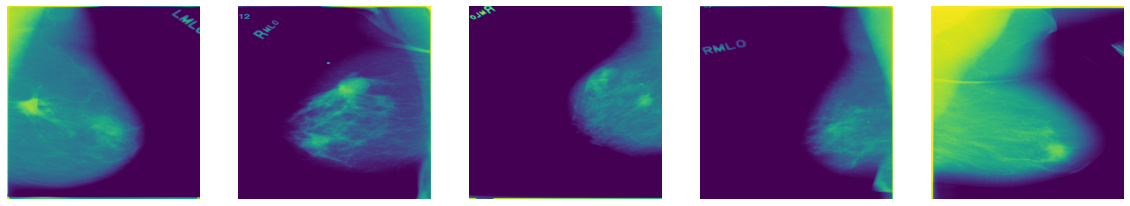

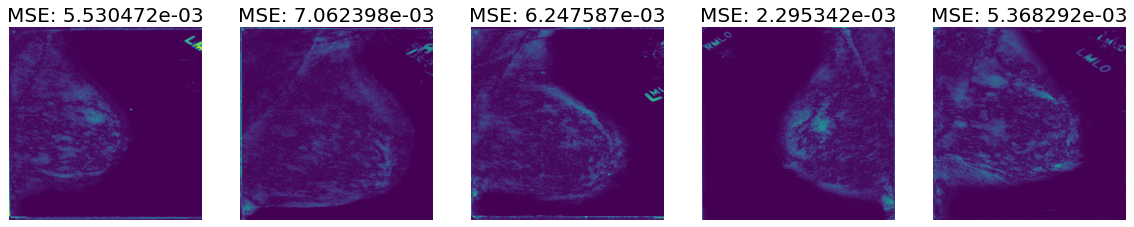

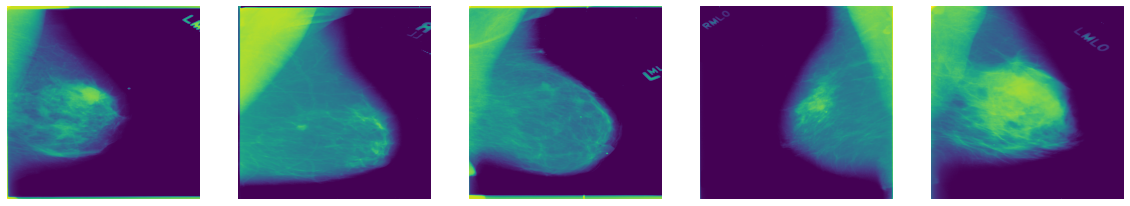

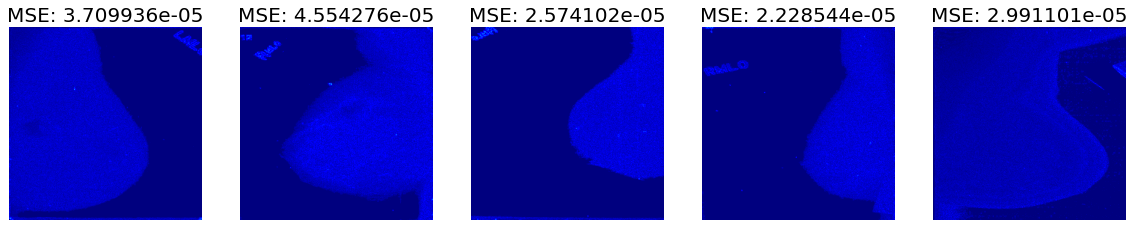

In [ ]:
from sklearn.metrics import mean_squared_error
import sys
import cv2
z_sample_train = encoder.predict(x_train, batch_size=16)
x_decoded_train = decoder.predict(z_sample_train , batch_size=16)

z_sample_test = encoder.predict(x_test, batch_size=16)
x_decoded_test = decoder.predict(z_sample_test , batch_size=16)

plt.figure(figsize=(20,10))
NUM_TO_VISUALIZE = 5
random_indices = np.arange(0 , 5) #np.random.randint(0 , len(x_train) , size=NUM_TO_VISUALIZE)

for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  num = "{:e}".format(mean_squared_error(np.squeeze(x_train[random_indices[i]]) , np.squeeze(x_decoded_train[random_indices[i]])))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.imshow(np.abs(np.squeeze(x_decoded_train[i]) - np.squeeze(x_train[i])) ,cmap='jet')


plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  plt.imshow(np.squeeze(x_train[random_indices[i]]))

plt.figure(figsize=(20,10))
random_indices = np.arange(0 , 5) #np.random.randint(0 , len(x_test) , size=NUM_TO_VISUALIZE)
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  num = "{:e}".format(mean_squared_error(np.squeeze(x_test[random_indices[i]]) , np.squeeze(x_decoded_test[random_indices[i]])))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.imshow(np.abs(np.squeeze(x_decoded_test[i]) - np.squeeze(x_test[i])))


plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
  plt.axis('off')
  plt.imshow(np.squeeze(x_test[random_indices[i]]))

plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 85]
  result, encimg = cv2.imencode('.jpg', x_train[i] * 255., encode_param)
  decimg = cv2.imdecode(encimg, 0)
  plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
  num = "{:e}".format((mean_squared_error(np.squeeze(x_train[random_indices[i]]) , decimg / 255.)))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.axis('off')
  plt.imshow(np.abs(np.squeeze(decimg) / 255. - np.squeeze(x_train[i])) , cmap='jet')


## Print Sample Reconstructions

In [ ]:
z_sample = encoder.predict(x_test[0:16])
x_decoded = decoder.predict(z_sample)

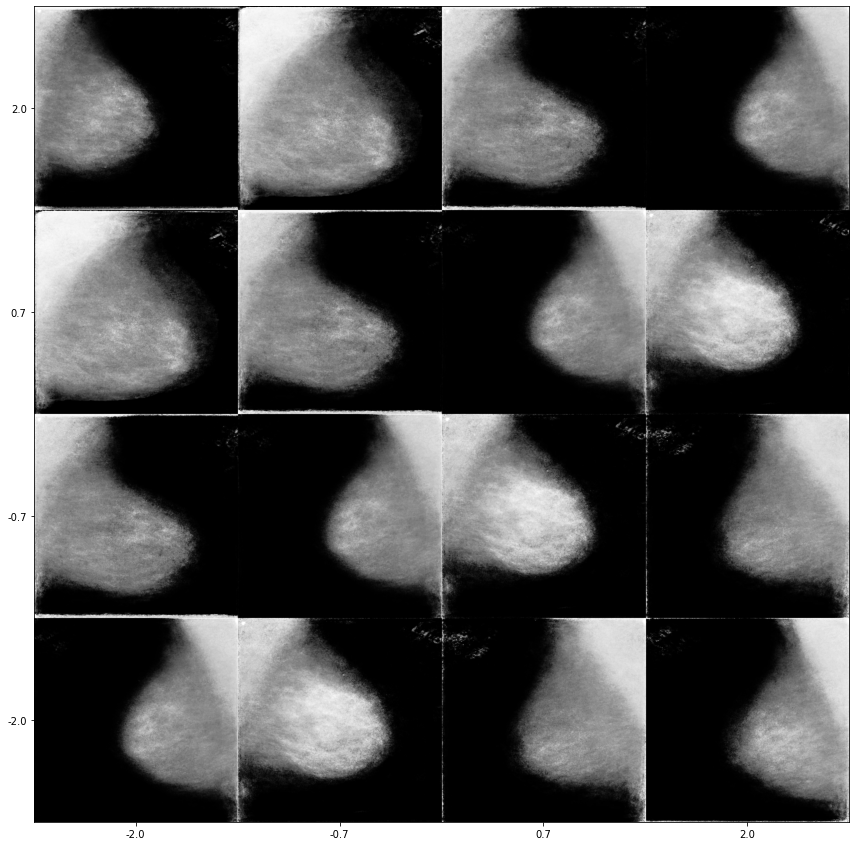

In [ ]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 4
    digit_size = 1024
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):   
            digit = x_decoded[i + j].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

## TSNE

In [ ]:
z_sample = encoder.predict(x_test , batch_size=16)
x_decoded = decoder.predict(z_sample , batch_size=16)

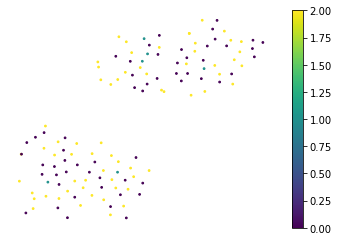

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# There is clear seperation due to the presence of right and left views in the data
tsne = TSNE()
X_valid_2D = tsne.fit_transform(z_sample)

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_test, s=3)
plt.colorbar()
plt.axis('off')
plt.show()

# Plotting differences

#### Get JPEG DATA


In [ ]:
x_train_jpg = []
encoding_size = []
for i in range(len(x_train)):
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 85]
  result, encimg = cv2.imencode('.jpg', x_train[i] * 255., encode_param)
  encoding_size.append(sys.getsizeof(encimg))
  decimg = cv2.imdecode(encimg, 0)
  x_train_jpg.append(decimg / 255.)


In [ ]:
z_sample_train = encoder.predict(x_train , batch_size=16)
x_decoded_train = decoder.predict(z_sample_train , batch_size=16)

In [ ]:
import pickle
with open(f"{ROOT}/data/pickles/vae-predictions.pickle" , "rb") as f:
  (vae_z_sample_train , vae_x_decoded_train) = pickle.load(f)

In [ ]:
len(vae_x_decoded_train)

509

array([0.99979668, 0.99984438, 0.99985943, 0.99987161, 0.99976946,
       0.99985884, 0.99975609, 0.99985118, 0.99985986, 0.99984605,
       0.99983927, 0.99987527, 0.99983884, 0.9998426 , 0.99982912,
       0.99980446, 0.99969342, 0.9998095 , 0.99978758, 0.99986537,
       0.99980043, 0.99979429, 0.9997835 , 0.9998607 , 0.99982527,
       0.99965874, 0.99978846, 0.99978978, 0.99984012, 0.9998855 ,
       0.99984459, 0.99979437, 0.9998356 , 0.99985445, 0.99965785,
       0.99976969, 0.99976429, 0.99979207, 0.99984251, 0.99980101,
       0.99978735, 0.99988041, 0.99980498, 0.99982174, 0.99985749,
       0.99972842, 0.9998485 , 0.99962517, 0.99932894, 0.99987791,
       0.99961585, 0.99976746, 0.99986398, 0.9998559 , 0.99984933,
       0.99983441, 0.99980512, 0.99976463, 0.99974244, 0.99990349,
       0.99980654, 0.99987176, 0.9998065 , 0.99982074, 0.99975292,
       0.99982044, 0.9998286 , 0.99982586, 0.99984222, 0.99967997,
       0.99982999, 0.99981602, 0.99981699, 0.99981747, 0.99984

In [ ]:
# # We use the Euclidean Norm
dist_train = [( 1 - mean_squared_error(np.squeeze(x_train[i]) , np.squeeze(x_decoded_train[i]))) for i in range(len(x_train)) ]
dist_jpeg_train = [( 1 - mean_squared_error(np.squeeze(x_train_jpg[i]) , np.squeeze(x_decoded_train[i]))) for i in range(len(x_train)) ]
# dist_test = [ np.linalg.norm(x_test[i] - x_decoded[i]) for i in range(len(x_test)) ]
size_train = [sys.getsizeof(z_sample_train[i]) for i in range(len(x_train))]

dist_vae_train = [(1 - mean_squared_error(np.squeeze(x_train[i]) , np.squeeze(vae_x_decoded_train[i]))) for i in range(len(x_train)) ]
dist_size_vae_train = [sys.getsizeof(vae_z_sample_train[2][i]) for i in range(len(x_train))]

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text major ticklabel objects>)

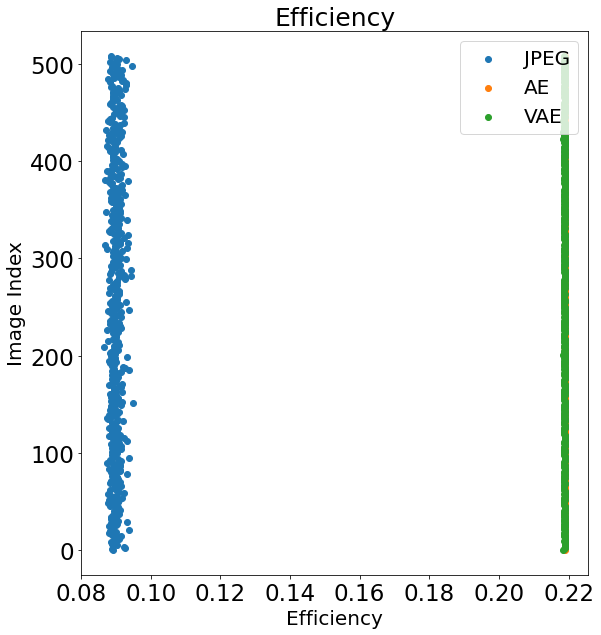

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(dist_jpeg_train / np.log(np.asarray(encoding_size)), np.arange(len(x_train)))
plt.scatter(np.asarray(dist_train) / np.log(96.) , np.arange(len(x_train)))
plt.scatter(dist_vae_train / np.log(np.asarray(dist_size_vae_train)), np.arange(len(x_train)))
# plt.xscale("log")
# plt.plot(np.arange(len(x_test)) , dist_test)
plt.title("Efficiency", fontsize=25)
plt.legend(['JPEG' , 'AE', 'VAE' ], loc='upper right', fontsize=20)
plt.xlabel("Efficiency" , fontsize=20)
plt.ylabel("Image Index" ,  fontsize=20)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text major ticklabel objects>)

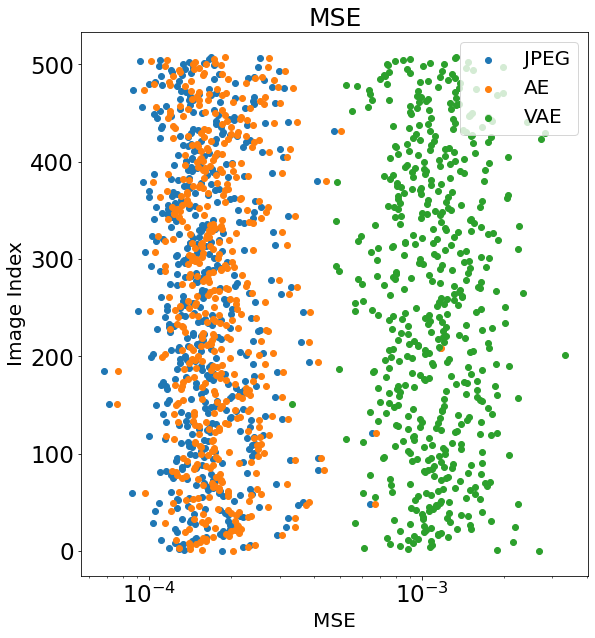

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(1 - np.asarray(dist_jpeg_train) , np.arange(len(x_train)))
plt.scatter(1 - np.asarray(dist_train) , np.arange(len(x_train)))
plt.scatter(1 - np.asarray(dist_vae_train) , np.arange(len(x_train)))
plt.xscale("log")
# plt.plot(np.arange(len(x_test)) , dist_test)
plt.title("MSE", fontsize=25)
plt.legend(['JPEG' , 'AE', 'VAE' ], loc='upper right', fontsize=20)
plt.xlabel("MSE" , fontsize=20)
plt.ylabel("Image Index" ,  fontsize=20)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

In [ ]:
# We use the Manhattan Norm
dist_train = [ np.linalg.norm(np.squeeze(x_train[i] - x_decoded_train[i]) , ord=1) for i in range(len(x_train)) ]
dist_test = [ np.linalg.norm(np.squeeze(x_test[i] - x_decoded[i]) , ord=1) for i in range(len(x_test)) ]

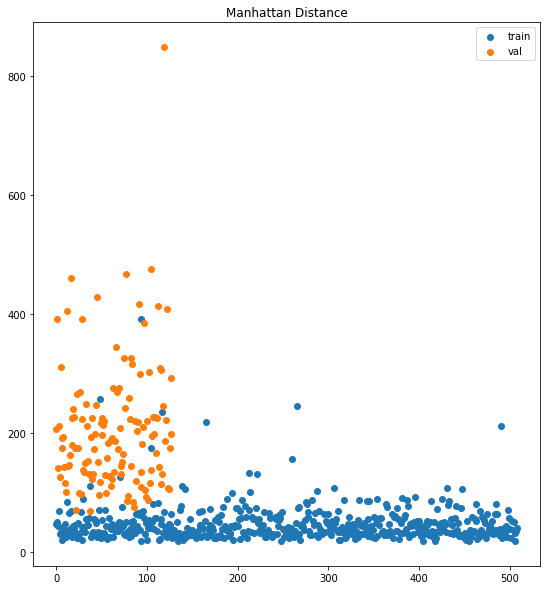

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(np.arange(len(x_train)) , dist_train)
plt.scatter(np.arange(len(x_test)) , dist_test)
plt.title("Manhattan Distance")
plt.legend(['train', 'val'], loc='upper right')

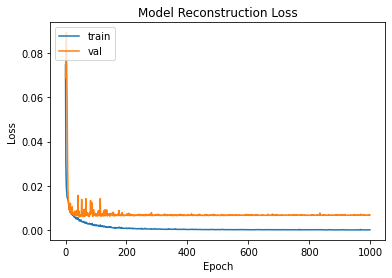

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Reconstruction Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Reload Model

In [ ]:
(encoder_n, decoder_n, autoencoder_n) = ConvAutoencoder.build(x_train.shape[1], x_train.shape[2], x_train.shape[3])
opt = Adam(lr=1e-3)
autoencoder_n.compile(loss="mse", optimizer=opt)
autoencoder_n.evaluate(x_test, x_test, verbose=2 , batch_size=16)

8/8 - 1s - loss: 0.1452


0.14515304565429688

In [ ]:
autoencoder_n.load_weights('/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT/AE-minimize-reconstruction/BEST-AE-weights-improvement-60-0.00.hdf5')

In [ ]:
autoencoder.save_weights('/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT/AE-minimize-reconstruction/AE-MODEL_1000_EPOCHS.h5')